# Ancora shared memory: l'algoritmo All-Pairs N-Body 

In questo notebook applicheremo il parallelismo ad un esempio tratto dal mondo reale: il problema degli $N$-corpi, o in inglese $N$-body. Questo problema è molto importante nell'ambito della fisica computazionale, infatti la soluzione analitica è nota solo con $N=2$ e in alcuni casi con $N=3$, perciò trovarne una soluzione numerica è fondamentale.

Dati $N$ corpi con posizioni iniziali $x_i$, massa $m_i$ e velocità $v_i$, $1 \leq i \leq N$, definiamo la forza $f_{ij}$ esercitata dal corpo $j$ sul corpo $i$ come
$$ f_{ij} = G\frac{m_im_j r_{ij}}{\Vert r_{ij} \Vert^3 }, $$
dove $r_{ij} = x_j - x_i$.
La forza fotale esercitata sul corpo $i$-esimo è dunque
$$ F_i = \sum_{j \neq i} f_{ij} = G m_i \sum_{j \neq i}  \frac{m_j r_{ij}}{\Vert r_{ij} \Vert^3 }. $$
Quando due particelle si avvicinano troppo, la forza $f_{ij}$ che agisce tra di loro va all'infinito. Per impedire problemi numerici, introduciamo un fattore di smorzamento $\varepsilon>0$
$$ F_i \approx G m_i \sum_{j}  \frac{m_j r_{ij}}{(\Vert r_{ij} \Vert^2 + \varepsilon^2)^{3/2} }. $$
La condizione $j \neq i$ non è più necessaria perchè quando $r_{ii} = 0$ il fattore di smorzamento impedisce che il denominatore vada a zero.

Per integrate le leggi del moto
$$ a(t) = \frac{dv}{dt}(t) = \frac{dx^2}{dt^2}(t), \\  v(t) = \frac{dx}{dt}(t), $$
abbiamo bisogno dell'accelerazione, che ricaviamo applicando la seconda legge di Newton $a = F/m$. L'accelerazione della particella $i$-esima è quindi data da
$$ a_i \approx G \sum_{j}  \frac{m_j \mathbf{r}_{ij}}{(\Vert r_{ij} \Vert^2 + \varepsilon^2)^{3/2} }. $$

Integriamo nel tempo ( in questo caso utilizzando il metodo di Eulero) e otteniamo l'evoluzione di posizione e velocità:
$$ v_{k+1} = a_k\cdot dt + v_k, \\  x_{k+1} = v_{k+1} \cdot dt + x_k = a_k\cdot dt^2 + v_k\cdot dt + x_k. $$

### Scelta dei tipi
Numba ancora non 

@article{article,
author = {Nyland, Lars and Harris, M and Prins, Jan},
year = {2009},
month = {01},
pages = {677-695},
title = {Fast N-body simulation with CUDA},
booktitle = {GPU Gem, Vol. 3}
}

In [1]:
import numpy as np
import time
from numba import cuda
from numba import float32, complex64, void
import math
import numba
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [2]:
EPS2 = 0.02

In [3]:
def a(i, x, m):
    """The acceleration of the ith mass."""
    x_i = x[i]
    #x = remove_i(x, i)
    #m = remove_i(m, i)
    diff   = x - x_i
    mag3   = np.power( np.sum( np.square(diff), axis=1)  + EPS2 , -1.5)
    result = np.sum( diff * (m * mag3)[:,np.newaxis], axis=0)
    return result

In [4]:
def timestep(x0, v0, m, dt):
    """Computes the next position and velocity for all masses given
    initial conditions and a time step size.
    """
    N = len(x0)
    x1 = np.empty(x0.shape, dtype=float)
    v1 = np.empty(v0.shape, dtype=float)
    #ac = np.empty(v0.shape, dtype=float)
    for i in range(N):
        a_i0  = a(i, x0, m)
        #ac[i,:] = a_i0
        v1[i,:] = a_i0 * dt + v0[i,:]
        x1[i,:] = a_i0 * dt * dt + v0[i,:] * dt + x0[i,:]
    #endfor
    #print(ac)
    return x1, v1

In [5]:
def initial_cond(N, D):
    """Generates initial conditions for N unity masses at rest
    starting at random positions in D-dimensional space.
    """
    x0 = np.random.rand(N, D)
    v0 = np.zeros((N, D), dtype=float)
    m = np.ones(N, dtype=float)
    return x0, v0, m

In [6]:
def simulate(x0, v0, m, N, S, dt):
    for s in range(S):
        x1, v1 = timestep(x0, v0, m, dt)
        x0, v0 = x1, v1
    #endfor
    return x0, v0

In [7]:
N = 32
m = np.ones(N, dtype=float)
x0 = np.random.rand(N, 2)
v0 = np.zeros((N, 2), dtype=float)

In [8]:
start = time.time()
xs, vs = simulate(x0, v0, m, N, 1, 1e-3)
stop = time.time()

In [9]:
def plot_Nbody(x,v):
    fig, ax = plt.subplots()
    ax.quiver(x[:,0],x[:,1],v[:,0],v[:,1])
    plt.scatter(x[:,0],x[:,1], c='r', marker ='o')
    return

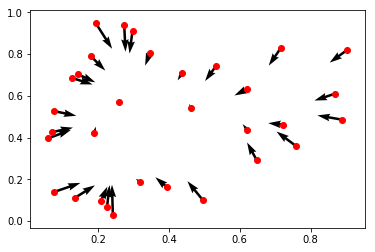

In [10]:
plot_Nbody(xs,vs)

# Implementiamo All-Pairs N-Body con CUDA Python

L'dea generale dell'algoritmo *all-pairs* è che ogni particella venga assegnata ad thread, che ne calcola l'accerelazione. Il thread $i$-esimo calcola una ad una le interazioni $f_{ij}$ tra la particella $i$ e tutte le altre particelle $j$ con $1 \leq j \leq N$, sommando man mano le iterazioni per ottenere l'accelerazione risultante $a_i$. 

Il kernel così definito è 1D. I threads sono suddivisi in blocchi composti da $p$ threads. Per calcolare $f_{ij}$, il thread $i$ ha bisogno dei dati $m_j$, $x_j$, perciò **ogni dato viene letto esattamente $N$ volte**, una per thread.

Per ottimizziare il riutilizzo dei dati, utilizziamo la shared memory. Come abbiamo visto, la shared memory è condivisa tra i threads di uno stesso blocco. 

Ogni blocco carica in shared la posizione $x$ e la massa $m$ di $p$ particelle per volta, dopodiché una barriera di sincronizzazione assicura che il trasferimento in memoria sia stato ultimato. Ogni thread calcola poi in maniera seriale le interazioni tra la particella assegnatagli e le particelle in shared e somma le interazioni. I thread vengono sincronizzati un'altra volta, così che tutte le interazioni siano state aggiornate, e il processo ripete con le successive $p$ particelle. 

Una volta che tutte le particelle sono state caricate, ogni thread ha calcolato in maniera incrementale l'accelerazione per la particella assegnatagli e scrive il risultato nell'array di output in memoria global.

![](http://media2mult.uos.de/pmwiki/fields/gpu09/m2m.d/N-Body-Simulation.SimulationWithCUDA/media/image/algorithm.png)

In [11]:
TILE = 32 #multiple of 32
threadsperblock = TILE

@cuda.jit('complex64(complex64, complex64, float32, complex64)',device = True)
def twobodiesinteraction(A, B, mB, acc):
    #r_ij
    rx = B.real - A.real 
    ry = B.imag - A.imag
    
    distSqrt = rx*rx + ry*ry + EPS2
    
    f = mB*math.pow(distSqrt, -1.5)
    
    acc_new = acc + rx * f + 1j * ry*f
    return acc_new

@cuda.jit('void(complex64[:], float32[:], complex64[:])')
def forces_calculation(positions, mass, accelerations):
    gidx = cuda.grid(1)
    lidx = cuda.threadIdx.x
    idPosition = positions[gidx]

    
    shPosition = cuda.shared.array(shape=(TILE), dtype = complex64)
    shMass  = cuda.shared.array(shape=(TILE), dtype = float32)
    tile = 0
    acc  = complex64(0.0 +1j*0.0)
    N = positions.shape[0]
    
    if (gidx >= N): return
    
    for i in range(0, N, TILE):
        idx = tile*TILE + lidx
        #if (idx>=N): break
        shPosition[lidx] = positions[idx]
        shMass[lidx]     = mass[idx]
        cuda.syncthreads()
        #tile calculation
        for j in range(0,TILE):
            acc = twobodiesinteraction(idPosition, shPosition[j], shMass[j], acc)
        cuda.syncthreads()
        tile = tile + 1
    #endfor
    accelerations[gidx] = acc

In [12]:
@cuda.jit
def update_variables(a, x, v, dt, x_new, v_new):
    gidx = cuda.grid(1)
    
    if (gidx >= a.shape[0]): return
    v_new[gidx] = a[gidx]*dt     + v[gidx] 
    x_new[gidx] = v_new[gidx]*dt + x[gidx]


def simulate_gpu(x0, v0, m, N, maxit, dt):
    """Computes the next position and velocity for all masses given
    initial conditions and a time step size.
    """
    blockspergrid = math.ceil(N/threadsperblock)
    
    d_x0 = numba.cuda.to_device(x0)
    d_v0 = numba.cuda.to_device(v0)
    d_m  = numba.cuda.to_device(m)
    d_x1 = numba.cuda.device_array_like(x0)
    d_v1 = numba.cuda.device_array_like(v0) 
    d_a  = numba.cuda.device_array_like(x0) 

    
    for s in range(maxit):
        forces_calculation[blockspergrid, threadsperblock](d_x0, d_m, d_a)
        #print(d_a.copy_to_host())
        update_variables[blockspergrid, threadsperblock](d_a, d_x0, d_v0, dt, d_x1, d_v1)        
        d_x0.copy_to_device(d_x1)
        d_v0.copy_to_device(d_v1)
    #endfor

    return d_x1.copy_to_host(), d_v1.copy_to_host()

In [13]:
x0 = np.array(x0[:,0]+1j*x0[:,1], dtype = np.complex64)
#x0 = np.random.rand(N).astype(np.float32)+1j*np.random.rand(N).astype(np.float32)
v0 = np.zeros((N,), dtype=np.complex64)
m  = np.ones(N, dtype=np.float32)

In [14]:
x, v = simulate_gpu(x0, v0, m, N, 1, 1e-3)

In [15]:
def plot_cNbody(x,v):
    fig, ax = plt.subplots()
    ax.quiver(x.real,x.imag,v.real,v.imag)
    plt.scatter(x.real,x.imag, c='r', marker ='o')
    return

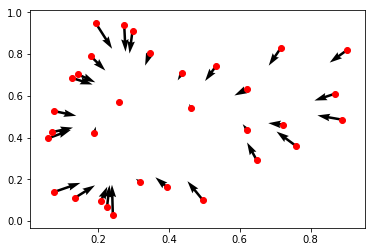

In [16]:
plot_cNbody(x,v)

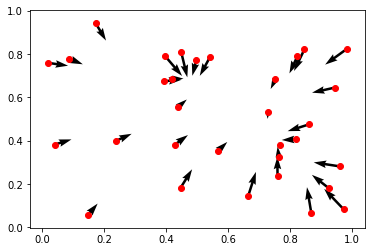

In [18]:
plot_Nbody(xs,vs)

# Confronto

Per confrontare le due implementazioni, calcoliamo i tempi di esecutione per le simulazioni con $100$ passi temporali al variare del numero di particelle $N$. 

In [19]:
iters = 100

num_particles = [32, 64, 128, 256, 512, 1024]
cpu_time = np.zeros(len(num_particles))
gpu_time = np.zeros(len(num_particles))

for i, N in enumerate(num_particles):
    m  = np.ones(N, dtype=float)
    x0 = np.random.rand(N, 2)
    v0 = np.zeros((N, 2), dtype=float)
    
    start = time.time()
    x, v = simulate(x0, v0, m, N, iters, 1e-3)
    end = time.time()
    cpu_time[i] = end-start
    
    x0 = np.array(x0[:,0]+1j*x0[:,1], dtype = np.complex64)
    v0 = np.zeros((N,), dtype=np.complex64)
    
    start = time.time()
    x, v = simulate_gpu(x0, v0, m, N, iters, 1e-3)
    end = time.time()
    gpu_time[i] = end-start    

#end

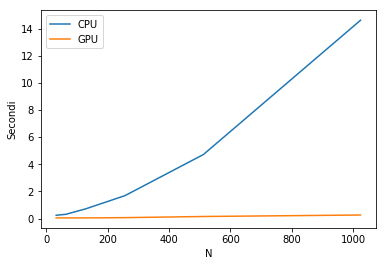

55.83995833629499


In [23]:
plt.figure()
plt.plot(num_particles, cpu_time)
plt.plot(num_particles, gpu_time)
plt.legend(['CPU', 'GPU'])
plt.xlabel('N')
plt.ylabel('Secondi')
plt.show()
print('Speed-up:', cpu_time[5]/gpu_time[5])

Per $1024$ particelle le simulazioni in CUDA Python sono quasi $56$ volte più veloci rispetto al classico Python, nonostante stiamo calcolando anche i tempi di trasferimento in memoria tra host e device.

Calcoliamo ora i tempi di esecuzione delle simulazioni in CUDA Python al variare della taglia del blocchi `TILE`. 

In [21]:
bs = [16, 32, 64]
num_particles = [32, 64, 128, 256, 512, 1024]

gpu_time_bs = np.zeros((len(num_particles),len(bs))) 

for i, N in enumerate(num_particles):
    x0 = np.random.rand(N).astype(np.float32)+1j*np.random.rand(N).astype(np.float32)
    v0 = np.zeros((N,), dtype=np.complex64)
    m  = np.ones(N, dtype=np.float32)
    for j, p in enumerate(bs):    
        TILE = p #multiple of 32
        threadsperblock = p
    
        start = time.time()
        x, v = simulate_gpu(x0, v0, m, N, iters, 1e-3)
        end = time.time()
        gpu_time_bs[i,j] = end-start    
    #end
#end

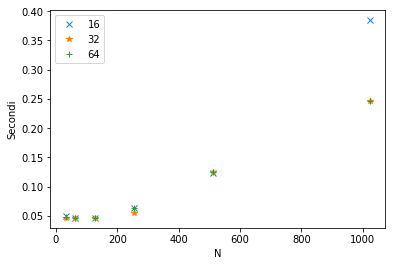

In [25]:
plt.figure()
plt.plot(num_particles, gpu_time_bs[:,0], 'x')
plt.plot(num_particles, gpu_time_bs[:,1], '*')
plt.plot(num_particles, gpu_time_bs[:,2], '+')
plt.legend(['16', '32', '64'])
plt.xlabel('N')
plt.ylabel('Secondi')
plt.show()

Per $N \leq 512$ le performance sembrano equivalenti, mentre con $N=1024$ vediamo che scegliere `TILE` più piccolo della warpsize ($=32$) comporta un netto peggioramento delle performance! 


NB: quest'esempio è tratto dall'articolo *Fast N-Body Simulation with CUDA* di Nyland, Harris e Prins
http://media2mult.uos.de/pmwiki/fields/gpu09/index.php?n=N-Body-Simulation.Results